In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

# Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv0 = nn.Conv2d(1, 8, 3, padding=1) #input -Image size 28x28 & RF:1x1 Output RF: 3x3
        self.bn0 = nn.BatchNorm2d(8)
        self.conv01 = nn.Conv2d(8, 8, 3, padding=1) #input - RF:3x3 Output RF: 5x5
        self.bn01 = nn.BatchNorm2d(8)
        self.pool0 = nn.MaxPool2d(2, 2) #input - RF:5x5 Output RF: 10x10
        self.drop1 = nn.Dropout(0.1)
        
        self.conv1 = nn.Conv2d(8, 16, 3, padding=1) #input - RF:10x10 Output RF: 12x12
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1) #input - RF:12x12 Output RF: 14x14
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2) #input - RF:14x14 Output RF: 28x28
        self.drop2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) #input - RF:28x28 Output RF: 30x30
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1) #input - RF:30x30 Output RF: 32x32
        self.bn4 = nn.BatchNorm2d(32)
        self.avgpool = nn.AvgPool2d(7) #input - RF:32x32 Output RF: 38x38
        self.drop3 = nn.Dropout(0.1)        

        self.fc1 = nn.Linear(32,16)
        self.fc2 = nn.Linear(16,10)


    def forward(self, x):
        x = self.pool0(self.bn01(F.relu(self.conv01(self.bn0(F.relu(self.conv0(x)))))))
        x=self.drop1(x)
        x = self.pool1(self.bn2(F.relu(self.conv2(self.bn1(F.relu(self.conv1(x)))))))
        x=self.drop2(x)
        x = self.avgpool(self.bn4(F.relu(self.conv4(self.bn3(F.relu(self.conv3(x)))))))
        x=self.drop3(x)
        x = x.view(-1, 32)
        x = self.fc2(self.fc1(x))
        return F.log_softmax(x)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
print("Model Summary:")
summary(model, input_size=(1, 28, 28))
print("\n\nModel Architecture:\n\n")
print(model)

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
           Dropout-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,168
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
          Dropout-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 32, 7, 7]           4,640
      BatchNorm2d-14    

Convolution layers: 3 blocks, with each block having 2 Conv Layers of 8, 16 and 32 kernels of size 3x3, stride=1 and padding=1  
Batch Normalization Used  
Dropout used: 10% at the end each of the 3 blocks  
Global Average Pooling used to bring down the channel size from 7x7x32 to 1x1x32  
Total Parameters: 18,962

# Reading MNIST data

# Data Loader

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# Train Function

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

# Test Function

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc

# Defining optimizer and learning rate

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Running the model

In [ ]:
train_loss_values = []
test_loss_values = []

train_acc_values = []
test_acc_values = []

for epoch in range(1, 21):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)


Epoch 1 : 
Train set: Average loss: 0.2658, Accuracy: 81.20

Test set: Average loss: 0.110, Accuracy: 96.65

Epoch 2 : 
Train set: Average loss: 0.0619, Accuracy: 97.35

Test set: Average loss: 0.041, Accuracy: 98.66

Epoch 3 : 
Train set: Average loss: 0.0540, Accuracy: 98.05

Test set: Average loss: 0.039, Accuracy: 98.71

Epoch 4 : 
Train set: Average loss: 0.0376, Accuracy: 98.38

Test set: Average loss: 0.037, Accuracy: 98.85

Epoch 5 : 
Train set: Average loss: 0.0350, Accuracy: 98.64

Test set: Average loss: 0.028, Accuracy: 99.04

Epoch 6 : 
Train set: Average loss: 0.0745, Accuracy: 98.72

Test set: Average loss: 0.026, Accuracy: 99.14

Epoch 7 : 
Train set: Average loss: 0.0307, Accuracy: 98.84

Test set: Average loss: 0.025, Accuracy: 99.18

Epoch 8 : 
Train set: Average loss: 0.0736, Accuracy: 98.92

Test set: Average loss: 0.024, Accuracy: 99.27

Epoch 9 : 
Train set: Average loss: 0.0105, Accuracy: 98.98

Test set: Average loss: 0.022, Accuracy: 99.31

Epoch 10 : 
Train 

# Plotting the train and test loss across each epoch

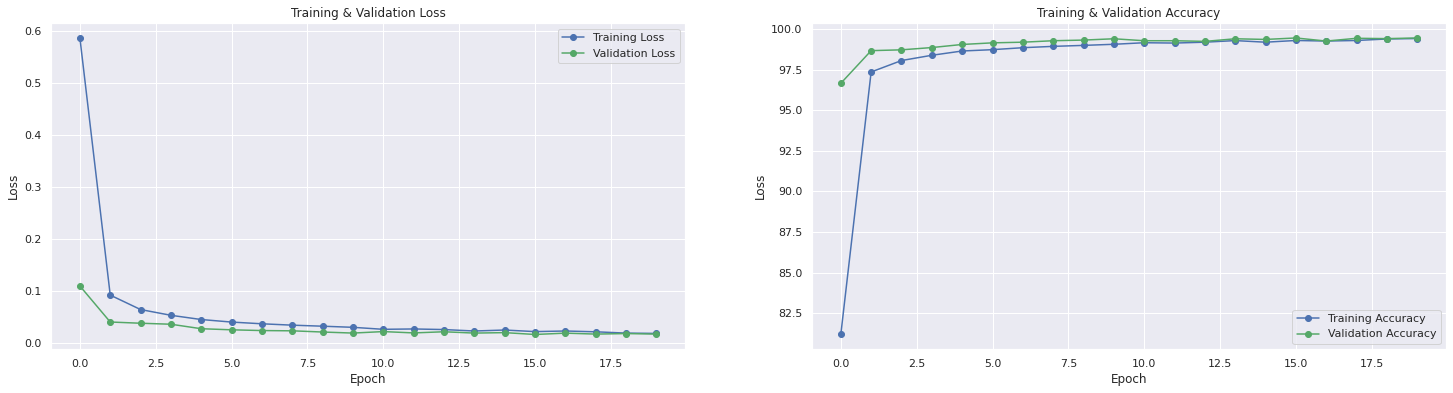

In [ ]:
# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'b-o', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'g-o', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_acc_values), 'b-o', label="Training Accuracy")
ax2.plot(np.array(test_acc_values), 'g-o', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

# Average Validation Loss

In [ ]:
print(f'Average Validation loss: {test_loss:.3f}')

Average Validation loss: 0.018
